# Location Modeling with the UJIIndoorLoc Dataset

The modeling task is to produce models for building id, floor, longitude, and latitude. The dependent variables are observations of wireless access signal strength as measured in dBm and expressed as a value between -100 and 0. Nulls are encoded as 100. 


This notebook represents the data exploration and model development portion of the assignment. The completed model is persisted in `location_model.pkl`. The script `modelclasses.py` contains the class and function definitions required to open the .pkl file. The class `LocationModel` implements the fit and predict methods required to train and generate predictions. See the docstring in `LocationModel` in `modelclasses.py` for documentation on required inputs and outputs.  





In [1]:
from pandas import read_csv, DataFrame
import numpy as np
import itertools
from math import sqrt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler as ssc
from sklearn.neighbors import KNeighborsRegressor as knr
from sklearn.ensemble import RandomForestClassifier as rfc, RandomForestRegressor as rfr
# from xgboost.sklearn import XGBRegressor
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

### Data Exploration

The objective here is twofold: understand what is in the data, and determine anything that might require cleaning before we begin modeling.

We already know a few things that might need to be taken into account:
- Measurements for the independent variables are given in dBm, which may or may not matter when we look at the distribution, as dBm is on a log scale. 
- Nulls are encoded as 100, which given how dBm is measured doesn't make any mathematical sense. Essentially, we should aim to represent nulls as 'lowest signal possible'.
- I am going to assume that columns/rows with 0 connections can be dropped, but columns/rows with a single connection are probably going to need to stay.


In [2]:
def plot_confusion_matrix(observed, predicted,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    cm = confusion_matrix(observed, predicted)
    classes = list(observed.unique())
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print('F1 Score: %s'%f1_score(list(observed), list(predicted), average='micro'))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [3]:
data = read_csv('trainingData.csv')

In [5]:
data2 = data[:10]

In [9]:
[i for i in data2.columns.values if 'WAP' not in i]

['LONGITUDE',
 'LATITUDE',
 'FLOOR',
 'BUILDINGID',
 'SPACEID',
 'RELATIVEPOSITION',
 'USERID',
 'PHONEID',
 'TIMESTAMP']

In [7]:
data2.transpose()

,0,1,2,3,4,5,6,7,8,9
WAP001,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
WAP002,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
WAP003,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
WAP004,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
WAP005,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
WAP006,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
WAP007,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
WAP008,1.000000e+02,1.000000e+02,-9.700000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
WAP009,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
WAP010,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02


In [4]:
data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [5]:
data.replace(100, np.nan, inplace=True)
data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']] = \
data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']].astype(str)

In [6]:
x_columns = [i for i in data.columns.values if 'WAP' in i]
metadata_fields = [i for i in data.columns.values if 'WAP' not in i]

In [7]:
data[x_columns].describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
count,18.000000,19.000000,0.0,0.0,40.000000,308.000000,578.000000,677.000000,595.000000,87.000000,...,1653.000000,14.000000,123.000000,126.000000,60.000000,3038.000000,4543.000000,22.000000,3.000000,0.0
mean,-95.333333,-87.894737,NaN,NaN,-92.525000,-85.746753,-81.652249,-81.988183,-77.793277,-91.632184,...,-81.218996,-89.571429,-81.333333,-84.603175,-87.233333,-72.557604,-76.023993,-91.545455,-96.000000,NaN
std,1.137593,2.051957,NaN,NaN,2.148195,8.343256,11.486342,9.680083,10.239520,3.760613,...,12.427483,5.258170,5.580509,4.897476,4.533740,14.605846,12.056910,3.725425,1.732051,NaN
min,-97.000000,-90.000000,NaN,NaN,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,...,-103.000000,-97.000000,-92.000000,-90.000000,-97.000000,-101.000000,-101.000000,-97.000000,-97.000000,NaN
25%,-96.000000,-90.000000,NaN,NaN,-94.000000,-91.000000,-91.000000,-88.000000,-87.000000,-95.000000,...,-90.000000,-95.000000,-86.000000,-88.000000,-91.250000,-84.000000,-85.000000,-95.000000,-97.000000,NaN
50%,-96.000000,-86.000000,NaN,NaN,-92.000000,-88.000000,-84.000000,-85.000000,-78.000000,-90.000000,...,-84.000000,-86.000000,-82.000000,-86.000000,-85.000000,-74.000000,-77.000000,-91.000000,-97.000000,NaN
75%,-94.250000,-86.000000,NaN,NaN,-91.750000,-82.750000,-75.000000,-76.000000,-71.000000,-90.000000,...,-72.000000,-85.000000,-77.000000,-83.000000,-84.000000,-63.000000,-70.000000,-88.000000,-95.500000,NaN
max,-93.000000,-86.000000,NaN,NaN,-89.000000,-58.000000,-47.000000,-61.000000,-50.000000,-84.000000,...,-2.000000,-85.000000,-70.000000,-67.000000,-82.000000,0.000000,0.000000,-87.000000,-94.000000,NaN


In [8]:
data[metadata_fields].describe(include=['object'])

,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID
count,19937,19937,19937,19937,19937,19937
unique,5,3,123,2,18,16
top,3,2,202,2,11,14
freq,5048,9492,484,16608,4516,4835


In [9]:
data[['BUILDINGID','FLOOR']].groupby(['BUILDINGID','FLOOR']).size()

BUILDINGID  FLOOR
0           0        1059
            1        1356
            2        1443
            3        1391
1           0        1368
            1        1484
            2        1396
            3         948
2           0        1942
            1        2162
            2        1577
            3        2709
            4        1102
dtype: int64

In [10]:
data[['LONGITUDE', 'LATITUDE']].describe()

,LONGITUDE,LATITUDE
count,19937.000000,1.993700e+04
mean,-7464.275947,4.864871e+06
std,123.402010,6.693318e+01
min,-7691.338400,4.864746e+06
25%,-7594.737000,4.864821e+06
50%,-7423.060900,4.864852e+06
75%,-7359.193000,4.864930e+06
max,-7300.818990,4.865017e+06


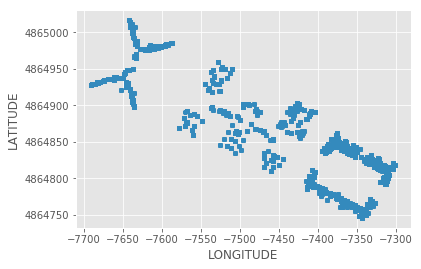

In [11]:
data.plot.scatter('LONGITUDE', 'LATITUDE')

It looks like there are definitely some columns (and possibly some rows) that are entirely null. We will drop both from the training data if they're there. 

In [12]:
print('data pre-drop ',data.shape)
data.dropna(how='all', axis=1, inplace=True)
data.dropna(how='all', axis=0, inplace=True)
print('data post-drop ', data.shape)
#Also update our list of input columns
x_columns = [i for i in data.columns.values if 'WAP' in i]

data pre-drop  (19937, 529)
data post-drop  (19937, 474)


Now we're going to look at the distribution of signal strength, and the distribution of connections for each access point. 

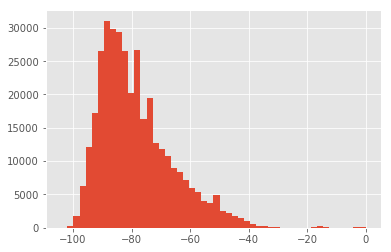

In [13]:
data[x_columns].stack().hist(bins=50)

It looks like there's some right skewness here. One thing to try during model development will be rescaling. 

In [14]:
data[x_columns].stack().min()

-104.0

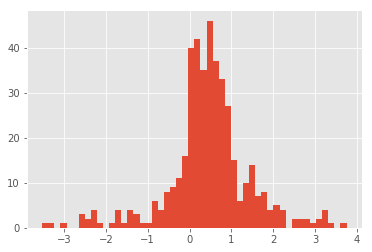

In [15]:
data[x_columns].skew().hist(bins=50)

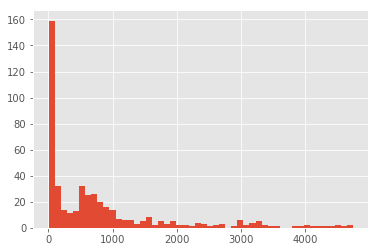

In [28]:
#Here' we're going to look at the distribution of records across WAPs.
data[x_columns].count().hist(bins=50)

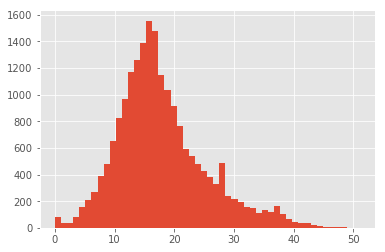

In [17]:
data[x_columns].count(axis=1).hist(bins=50)

In [18]:
data_norm_scale = np.power(10,data[x_columns]/10,)

In [19]:
data_norm_scale.describe()

,WAP001,WAP002,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,...,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519
count,1.800000e+01,1.900000e+01,4.000000e+01,3.080000e+02,5.780000e+02,6.770000e+02,5.950000e+02,8.700000e+01,2.956000e+03,2.983000e+03,...,1.000000e+00,1.653000e+03,1.400000e+01,1.230000e+02,1.260000e+02,6.000000e+01,3.038000e+03,4.543000e+03,2.200000e+01,3.000000e+00
mean,3.028256e-10,1.795730e-09,6.270040e-10,4.967492e-08,3.691462e-07,7.115804e-08,2.622416e-07,1.012703e-09,5.403109e-04,3.223629e-03,...,1.995262e-10,1.327011e-03,1.845213e-09,1.630365e-08,1.015603e-08,2.763273e-09,3.863118e-03,3.130109e-03,9.581295e-10,2.657199e-10
std,8.362135e-11,7.755814e-10,3.015201e-10,2.116538e-07,1.946379e-06,1.563738e-07,9.695467e-07,1.043779e-09,1.345044e-02,5.493915e-02,...,NaN,2.534614e-02,1.402442e-09,2.240715e-08,2.905687e-08,1.787388e-09,6.114994e-02,5.444595e-02,7.015158e-10,1.146508e-10
min,1.995262e-10,1.000000e-09,1.995262e-10,1.584893e-10,1.258925e-10,1.584893e-10,1.584893e-10,1.258925e-10,7.943282e-11,7.943282e-11,...,1.995262e-10,5.011872e-11,1.995262e-10,6.309573e-10,1.000000e-09,1.995262e-10,7.943282e-11,7.943282e-11,1.995262e-10,1.995262e-10
25%,2.511886e-10,1.000000e-09,3.981072e-10,7.943282e-10,7.943282e-10,1.584893e-09,1.995262e-09,3.162278e-10,3.162278e-09,3.162278e-09,...,1.995262e-10,1.000000e-09,3.162278e-10,2.511886e-09,1.584893e-09,7.534855e-10,3.981072e-09,3.162278e-09,3.162278e-10,1.995262e-10
50%,2.511886e-10,2.511886e-09,6.309573e-10,1.584893e-09,3.981072e-09,3.162278e-09,1.584893e-08,1.000000e-09,2.511886e-08,2.511886e-08,...,1.995262e-10,3.981072e-09,2.511886e-09,6.309573e-09,2.511886e-09,3.162278e-09,3.981072e-08,1.995262e-08,7.943282e-10,1.995262e-10
75%,3.776373e-10,2.511886e-09,6.718001e-10,5.336298e-09,3.162278e-08,2.511886e-08,7.943282e-08,1.000000e-09,1.995262e-07,1.995262e-07,...,1.995262e-10,6.309573e-08,3.162278e-09,1.995262e-08,5.011872e-09,3.981072e-09,5.011872e-07,1.000000e-07,1.584893e-09,2.988167e-10
max,5.011872e-10,2.511886e-09,1.258925e-09,1.584893e-06,1.995262e-05,7.943282e-07,1.000000e-05,3.981072e-09,5.011872e-01,1.000000e+00,...,1.995262e-10,6.309573e-01,3.162278e-09,1.000000e-07,1.995262e-07,6.309573e-09,1.000000e+00,1.000000e+00,1.995262e-09,3.981072e-10


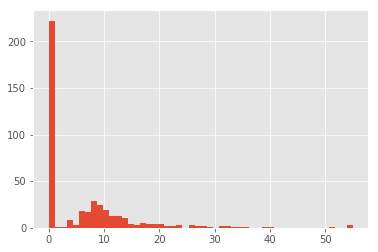

In [30]:
data_norm_scale[x_columns].skew().hist(bins=50)

In [20]:
data_norm_scale.stack().min(), data_norm_scale.stack().max()

(3.9810717055349695e-11, 1.0)

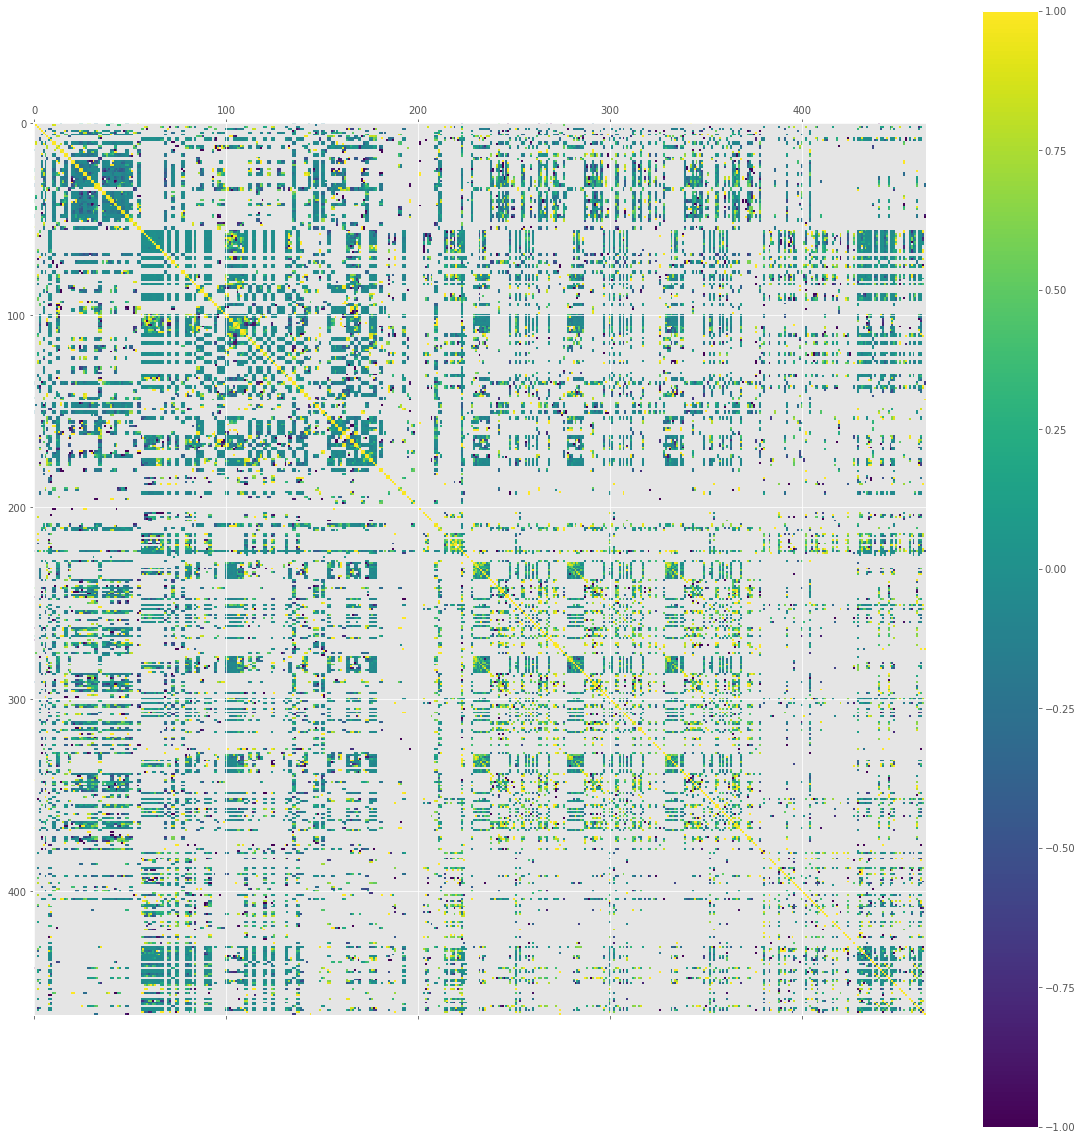

In [21]:
correlation_matrix = data_norm_scale.corr()
plt.figure(figsize=(20,20))
ax =  plt.matshow(correlation_matrix, fignum=1)
plt.colorbar(ax)

### Modeling

This task requires predictions for 4 variables: FLOOR, BUILDINGID, LONGITUDE, and LATITUDE.
The general approach is this: predict building for each record, and predict floor, longitude, and lattitude based on the predicted building. 

- Because there's significant cross-correlation between variables, I'm going to scale them and then apply a PCA.

- I tried a couple of different classifiers, but RandomForest seemed to work best for floor and building prediction, and KNN seemed to work best for location prediction. 


In [33]:
from IPython.display import display

class  DataPrep():
    def __init__(self):
        
        self.x_columns = []
        self.metadata_columns = []
        self.pca_columns = []
        self.scaler = ssc()
        self.pca = PCA()
        self.pre_pca_columns = []
        
    def fit(self,dat):
        
        data = dat.copy()
        data.loc[:,['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']] = \
        data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']].astype(str)
        
        x_columns_all = [i for i in data.columns.values if 'WAP' in i]
        data.loc[:,x_columns_all] = data.loc[:,x_columns_all].replace(100, np.nan)      

        data = data.dropna(how='all', axis=1)
        data = data.dropna(how='all', axis=0)
        
        self.pre_pca_columns = data.columns.values

        self.x_columns = [i for i in data.columns.values if 'WAP' in i]
        self.metadata_columns = [i for i in data.columns.values if 'WAP' not in i]
        
        data.loc[:,self.x_columns] = np.power(10,data[self.x_columns]/10)
        data.loc[:,self.x_columns] = data.loc[:,self.x_columns].fillna(0)
        self.scaler.fit(data[self.x_columns])
        data.loc[:,self.x_columns] = self.scaler.transform(data[self.x_columns])        
        self.pca.fit(data[self.x_columns])
        pca_data = DataFrame(self.pca.transform(data[self.x_columns]))
        self.pca_columns = ['PCA_%s'%i for i in pca_data.columns.values]
        components = DataFrame(data=[self.pca.n_components_, self.pca.explained_variance_ratio_], columns=['explained_variance'])
        components['cum_variance'] = components.explained_variance.cumsum()
        display(components)
        
    def transform(self,dat, dev=False):
        data = dat.copy()
            
        data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']] = \
        data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']].astype(str)
        data = data.loc[:,self.pre_pca_columns].copy()
        data.loc[:,self.x_columns] = data.loc[:,self.x_columns].replace(100, np.nan)
        data.loc[:,self.x_columns] = np.power(10,data[self.x_columns]/10)
        data.loc[:,self.x_columns] = data.loc[:,self.x_columns].fillna(0)
        data.loc[:,self.x_columns] = self.scaler.transform(data[self.x_columns]) 
        pca_data = DataFrame(self.pca.transform(data[self.x_columns]))
        
        self.pca_columns = ['PCA_%s'%i for i in pca_data.columns.values]
        pca_data.columns=self.pca_columns
        
        if dev:
            data['PARTITION'] = np.random.randint(0,3, size=len(data))
        else:
            pass
        
        
        for i in pca_data.columns.values:
            data.loc[:,i] = list(pca_data[i])
        
        return data

class LocationModel():
    def __init__(self):
        self.prep = DataPrep()
        self.building_model = None
        self.floor_models = {}
        self.location_models = {}


    def fit(self, data):

        '''
        data {pandas.DataFrame}: dataframe containing training data

        '''
        #Data Prep
        modeling_data = self.prep.fit(data)
        modeling_data = self.prep.transform(data, dev=True)
        building_training = modeling_data[modeling_data.PARTITION == 0].copy()
        location_training = modeling_data[modeling_data.PARTITION == 1].copy()
        test = modeling_data[modeling_data.PARTITION == 2].copy()
        
        #Building Model
        self.building_model = rfc(n_estimators = 200)
        
        self.building_model.fit(building_training[self.prep.pca_columns], building_training['BUILDINGID'])
        results = self.building_model.predict(test[self.prep.pca_columns])
        plot_confusion_matrix(test['BUILDINGID'], results, normalize=True)
      
        
        #Train Floor model based on building
        for i in modeling_data.BUILDINGID.unique():
            floordata = building_training[building_training.BUILDINGID == i]
            floortestdata = test[test.BUILDINGID == i]
            
            # Floor Model
            floor_model = rfc(n_estimators = 200)
            
            floor_model.fit(floordata[self.prep.pca_columns], floordata['FLOOR'])
            results = floor_model.predict(floortestdata[self.prep.pca_columns])
            print('Confusion Matrix for floor prediction, Building %s'%i)
            plot_confusion_matrix(floortestdata['FLOOR'], results, normalize=True)
            self.floor_models[str(i)] = floor_model

        #Train location model based on building
        for i in modeling_data.BUILDINGID.unique():
            locationdata = location_training[location_training.BUILDINGID == i]
            locationtestdata = test[test.BUILDINGID == i]
            
            location_model = knr(algorithm='auto', leaf_size=30, metric='manhattan',
                  metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                  weights='distance')
            
            location_model.fit(locationdata[self.prep.pca_columns], locationdata[['LONGITUDE', 'LATITUDE']])
            results = DataFrame(location_model.predict(locationtestdata[self.prep.pca_columns]), 
                                columns=['LONGITUDE', 'LATITUDE'])
            print('Buidlding %s lon RMSE: %s'%(i, sqrt(mean_squared_error(locationtestdata['LONGITUDE'], 
                                                                          results['LONGITUDE']))))
            print('Buidlding %s lat RMSE: %s'%(i, sqrt(mean_squared_error(locationtestdata['LATITUDE'], 
                                                                          results['LATITUDE']))))
            ax1 = locationtestdata.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', color='r')    
            ax2 = results.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', color='g', ax=ax1, title='building # %s'%i)
            
            self.location_models[str(i)] = location_model
        
    def predict(self, data):
        data = data.copy()
        data = self.prep.transform(data)

        building_prediction = self.building_model.predict(data[self.prep.pca_columns])
        data.loc[:,'BUILDINGID_PRED'] = building_prediction
        ids = data.BUILDINGID_PRED.unique()
        
        for bldg_id in data.BUILDINGID_PRED.unique():
            bldg_data = data[data.BUILDINGID_PRED == bldg_id]
            
            data.loc[data.BUILDINGID_PRED == bldg_id,'FLOOR_PRED'] = self.floor_models[str(bldg_id)].predict(bldg_data[self.prep.pca_columns])
            location = self.location_models[str(bldg_id)].predict(bldg_data[self.prep.pca_columns]) 
            data.loc[data.BUILDINGID_PRED == bldg_id, 'LON_PRED'] = [i[0] for i in location]
            data.loc[data.BUILDINGID_PRED == bldg_id, 'LAT_PRED'] = [i[1] for i in location]

        return data

            
            
        
        
    


In [ ]:
from sklearn.model_selection import train_test_split

data_original = read_csv('trainingData.csv')
# prep = DataPrep()
# prepped_data= prep.fit(data)
# test = prepped_data[prepped_data['PARTITION'] == 0]
# building_train = prepped_data[prepped_data['PARTITION'] == 1]
# location_train = prepped_data[prepped_data['PARTITION'] == 2]

train, test = train_test_split(data_original, test_size=0.15)

model = LocationModel()
model.fit(train)

### Final Evaluation

In [13]:
output = model.predict(test)

Longitude RMSE 19.519148986351215
Latitude RMSE 15.075123812774986


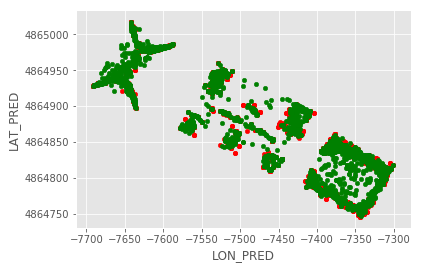

In [14]:
ax1 = output.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', color='r')    
ax2 = output.plot(kind='scatter', x='LON_PRED', y='LAT_PRED', color='g', ax=ax1)

print('Longitude RMSE', sqrt(mean_squared_error(output['LONGITUDE'], output['LON_PRED'])))
print('Latitude RMSE', sqrt(mean_squared_error(output['LATITUDE'], output['LAT_PRED'])))

Normalized confusion matrix
F1 Score: 0.992310264126


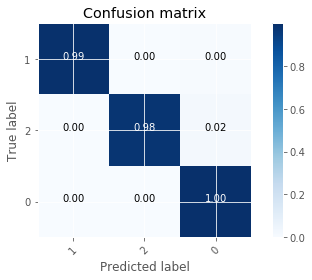

In [15]:
plot_confusion_matrix(output.BUILDINGID, output.BUILDINGID_PRED, normalize=True)

Normalized confusion matrix
F1 Score: 0.916081578068


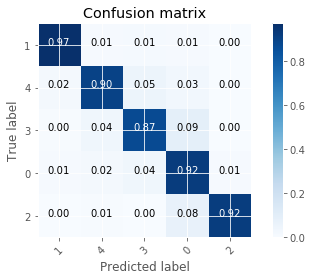

In [16]:
plot_confusion_matrix(output.FLOOR, output.FLOOR_PRED, normalize=True)

### Final performance stats:

Longitude RMSE 18.074337181547882  
Latitude RMSE 14.359511342336473  
Building F1 Score: 0.991975927783  
Floor F1 Score: 0.90270812
4373  

Building and Floor are, in aggregate, ok, but the location model could probably be improved by further localization. 

### Persist Model

In [17]:


import pickle
with open('location_model.pkl', 'wb') as outfile:
    pickle.dump(model, outfile)
    
    
    